Image Recognication and classification based on K means

In [54]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

np.random.seed(42)


# utility functions
def plot_mnist(elts, m, n, title):
    """Plot MNIST images in an m by n table. Note that we crop the images
    so that they appear reasonably close together.  Note that we are
    passed raw MNIST data and it is reshaped.

    Example: plot_mnist(X_train, 10, 10)
    """
    fig = plt.figure()
    images = [elt.reshape(28, 28) for elt in elts]
    img = np.concatenate([np.concatenate([images[m * y + x] for x in range(m)], axis=1)
                          for y in range(n)], axis=0)
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(img, cmap=matplotlib.cm.binary)
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    plt.title(title)
    plt.savefig('{}.eps'.format(title), format='eps')
    plt.show()


def plot_line(X, Y, title, xlabel, ylabel):
    # X,Y,title,xlabel,ylabel
    # function to make line plot for given X,Y
    # plt.plot(X, Y, style)
    plt.plot(X, Y, 'b-')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.grid(True)
    plt.savefig(title, format='eps')
    plt.show()


class KMeans:
    """K-Means clustering with random centroid initialization.

    Arguments:
        K : (int) default=10
            number of centroids
    """

    def __init__(self, K=10):
        self.K = K
        self.centroids = None

    def _init_centroids(self, X):
        """Compute the initial centroids
        
        Arguments:
            X : (ndarray, shape = (n_sample, n_features))
                Training input matrix where each row is a feature vector.

            K : (int) 
                number of centroids

        Returns:
            centers : (ndarray, shape = (K, n_features))
        """
        K = self.K
        #######################################
        # TODO: Write your code to randomly 
        # initialize K examples as centroids
        indexes = np.random.choice(list(range(X.shape[0])), size=(K,), replace=False)
        centers = X[indexes]
        #######################################
        return centers

    def _find_closest_centroids(self, X, centroids=None):
        """Finds the closest centroids for each example

        Arguments:
            X : (ndarray, shape = (n_sample, n_features))
                Training input matrix where each row is a feature vector.

            centroids : (None or ndarray, shape = (K, n_features))
                Cluster centers

        Returns:
            idx : (ndarray, shape = (n_samples,))
                Cluster id assigned to each example
        """
        if centroids is None:
            centroids = self.centroids

        idx = np.zeros((X.shape[0],), dtype=np.int)
        distances = np.zeros((X.shape[0], centroids.shape[0]))
        #######################################
        # TODO: Write your code to assign a 
        # cluster ID to each example
        # distances = np.linalg.norm(np.expand_dims(X, 1) - np.expand_dims(centroids, 0), axis=-1)
        for i in range(X.shape[0]):
            dists = np.linalg.norm(X[i] - centroids, axis=1)
            idx[i] = np.argmin(dists)
        #######################################

        return idx

    def _compute_centroids(self, X, idx):
        """Returns the new centroids by computing the means of the 
        data points assigned to each centroid

        Arguments:
            X : (ndarray, shape = (n_sample, n_features))
                Training input matrix where each row is a feature vector.

            idx : (ndarray, shape = (n_samples,))
                Cluster ids for each example

            K : (int) 
                number of centroids

        Returns:
            centroids : (ndarray, shape = (K, n_features))
                new cluster centers formed by taking means of data points
                assigned to old centroids
        """
        K = self.K
        centroids = np.zeros((self.K, X.shape[1]))
        #######################################
        # TODO: Write your code to compute the 
        # new centroids by computing the means of 
        # data points assigned to each cluster
        # Try to use maximum 1 loop over number of
        # samples in X
        # for i in range(K):
        #     centroids[i] = np.mean(X[np.argwhere(idx == i)], axis=0)
        N = np.zeros((K,))
        for i in range(X.shape[0]):
            centroids[idx[i]] += X[i]
            N[idx[i]] += 1
        for i in range(K):
            centroids[i] /= N[i]

        #######################################

        return centroids

    def score(self, X, idx=None, centroids=None):
        """Compute the score function

        Arguments:
            X : (ndarray, shape = (n_sample, n_features))
                Training input matrix where each row is a feature vector.

            idx : (None or ndarray, shape = (n_samples,))
                Cluster ids for each example

            centroids : (None or ndarray, shape = (K, n_features))
                Cluster centers

        Returns:
            score : (float) 
                negative within cluster scattering
        """
        if idx is None and centroids is None:
            idx, centroids = self.predict(X), self.centroids
        score = 0.0
        for k in range(self.K):
            score -= np.sum(np.linalg.norm(X[idx == k] - centroids[k], axis=1))
        return score

    def fit(self, X, max_iters=100, verbose=False):
        """Compute K-means clustering

        Arguments:
            X : (ndarray, shape = (n_sample, n_features))
                Training input matrix where each row is a feature vector.
            
            max_iters : (int)
                Maximum number of iteration to run K-Means algorithm

            verbose : (bool), default=False
                Verbosity mode 
        """
        prev_max_diff = 0.0
        centroids = self._init_centroids(X)

        for i in range(max_iters):

            idx = self._find_closest_centroids(X, centroids)
            prev_centroids = centroids
            centroids = self._compute_centroids(X, idx)

            if verbose:
                score = self.score(X, idx, centroids)
                print("Running K-Means Iteration : {}, Score : {}".format(i + 1, score))

            # early stopping
            diffs = map(lambda u, v: np.linalg.norm(u - v), prev_centroids, centroids)
            max_diff = max(diffs)
            diff_change = abs((max_diff - prev_max_diff) / np.mean([prev_max_diff, max_diff])) * 100
            prev_max_diff = max_diff

            if np.isnan(diff_change) or diff_change < 1e-4:
                print("Converged!")
                break

        # Store the final centroids
        self.centroids = centroids

    def predict(self, X):
        """Predicts cluster ids for samples in X based on current centroids

        Arguments:
            X : (ndarray, shape = (n_sample, n_features))
                Training input matrix where each row is a feature vector.

        Returns:
            idx : (ndarray, shape = (n_samples,))
                Cluster id assigned to each example
        """

        #######################################
        # TODO: Write your code to predict the 
        # cluster IDs for a given set of examples
        idx = self._find_closest_centroids(X)
        #######################################
        return idx


def main():
    # Read the data
    X_train = np.load('Data/X_train.npy')
    X_val = np.load('Data/X_val.npy')
    Y_train = np.load('Data/Y_train.npy')
    Y_val = np.load('Data/Y_val.npy')

    def q1():
        highest_score, selected_model = -np.inf, None
        for i in range(10):
            km = KMeans(K=10)
            np.random.seed(i)
            km.fit(X_train)
            score = km.score(X_val)

    km = KMeans(K=10)
    km.fit(X_train, verbose=True)
    idx_val = km.predict(X_val)
    idx_tr = km.predict(X_train)


if __name__ == '__main__':
    main()


Running K-Means Iteration : 1, Score : -65339.01410467099
Running K-Means Iteration : 2, Score : -63405.2616337847
Running K-Means Iteration : 3, Score : -62781.690927512784
Running K-Means Iteration : 4, Score : -62542.53447404253
Running K-Means Iteration : 5, Score : -62438.882671619016
Running K-Means Iteration : 6, Score : -62368.99389409598
Running K-Means Iteration : 7, Score : -62315.72362010807
Running K-Means Iteration : 8, Score : -62276.600265909256
Running K-Means Iteration : 9, Score : -62247.404036007836
Running K-Means Iteration : 10, Score : -62225.9048387345
Running K-Means Iteration : 11, Score : -62208.75478021823
Running K-Means Iteration : 12, Score : -62182.94969121537
Running K-Means Iteration : 13, Score : -62149.45395463391
Running K-Means Iteration : 14, Score : -62102.96036717354
Running K-Means Iteration : 15, Score : -62058.123067654284
Running K-Means Iteration : 16, Score : -62025.93760981524
Running K-Means Iteration : 17, Score : -62006.52301066614
Run

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in double_scalars


In [2]:
    # Read the data
X_train = np.load('Data/X_train.npy')
X_val = np.load('Data/X_val.npy')
Y_train = np.load('Data/Y_train.npy')
Y_val = np.load('Data/Y_val.npy')


In [3]:
highest_score, selected_model = -np.inf, None
for i in range(10):
    km = KMeans(K=10)
    np.random.seed(i)
    km.fit(X_train)
    score = km.score(X_val)
    if score > highest_score:
        highest_score = score
        selected_model = km

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:199: RuntimeWarning: invalid value encountered in double_scalars


Converged!
Converged!
Converged!
Converged!
Converged!
Converged!
Converged!
Converged!


In [4]:
idx = km.predict(X_val)

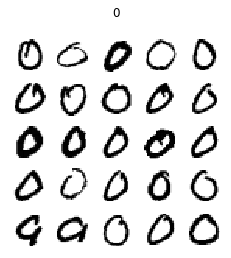

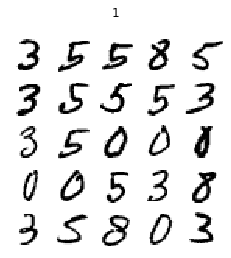

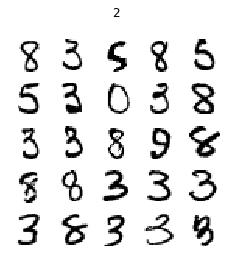

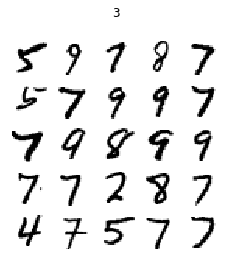

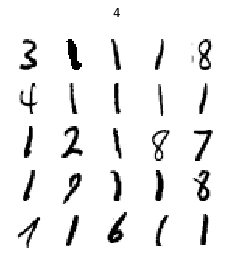

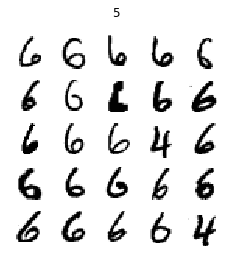

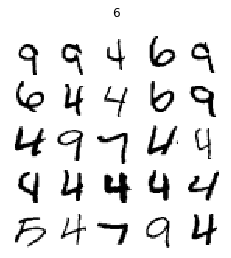

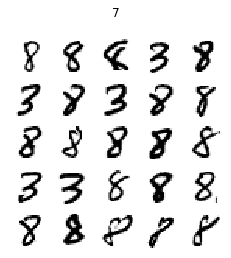

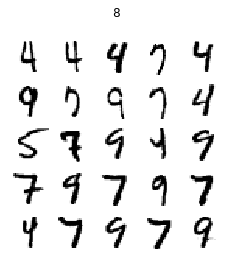

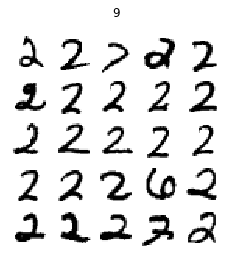

In [55]:
for i in range(len(set(idx))):
    data = X_val[np.argwhere(idx == i)]
    plot_mnist(data, 5, 5, i)

In [50]:
scores = []
ks = list(range(2, 17))
for k in ks:
    km = KMeans(K=k)
    km.fit(X_train)
    scores.append(km.score(X_val))

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:200: RuntimeWarning: invalid value encountered in double_scalars


Converged!
Converged!
Converged!
Converged!
Converged!
Converged!
Converged!
Converged!
Converged!
Converged!
Converged!
Converged!
Converged!


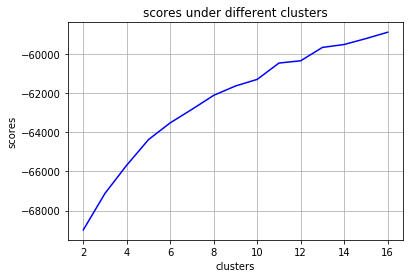

In [56]:
plot_line(ks, scores, 'scores under different clusters', 'clusters', 'scores')